### Intro Task Object Localization

In [1]:
!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 7.41 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
import pandas as pd
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
import sys
sys.path.append('./object-localization-dataset/')

 best_model.pth			     Object_Localisation.ipynb
 Human-Segmentation-Dataset-master   object-localization-dataset
'Image Segmentation.ipynb'


### Configuration

In [5]:
CSV = "./object-localization-dataset/train.csv"
DATA_DIR = "./object-localization-dataset/"

DEVICE = "cuda"

BATCH_SIZE= 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40 

MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [6]:
df = pd.read_csv(CSV)

In [7]:
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


## Understanding the dataset

In [14]:
row = df.iloc[184]            # 
img = cv2.imread(DATA_DIR + row.img_path)


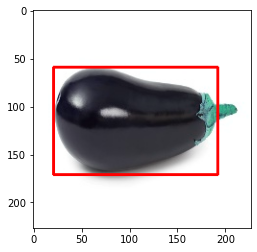

In [18]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img,pt1,pt2, (255,00,0),2 )
plt.imshow(bnd_box_img)

In [19]:
train_df , valid_df = train_test_split(df, test_size= 0.2, random_state=42)

## Augmentation

In [20]:
import albumentations as A

In [24]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p= 0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
],bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))


valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
],bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))



## Create Custom Dataset

In [25]:
class ObjectDataset(torch.utils.data.Dataset):

    def __init__(self, df , augmentation = None):
        self.df = df
        self.augmentation= augmentation

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]

        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.xmax

        bbox = [[xmin, ymin , xmax, ymax]]

        img_path = DATA_DIR + row.img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)

        if self.augmentation:
            data = self.augmentation(image = img , bboxes = bbox, class_labels= [None])

            img = data['image']
            bbox = data['bboxes'][0]

        img = torch.from_numpy(img).permute(2,0,1)/ 255.0
        bbox = torch.Tensor(bbox)

        return img , bbox
    
    

In [26]:
trainset = ObjectDataset(train_df , train_augs)
validset = ObjectDataset(valid_df, valid_augs)


In [27]:
print(len(trainset))
print(len(validset))

148
38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


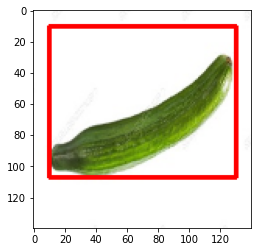

In [29]:
img , bbox = trainset[6]

xmin, ymin , xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1,2,0).numpy(), pt1, pt2, (255, 0, 0 ), 2)
plt.imshow(bnd_img)

## Load Dataset into Batches

In [31]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)


In [32]:
len(trainloader)

10

In [33]:
len(validloader)

3

In [34]:
for images , bboxes in trainloader: 
    break;

images.shape

torch.Size([16, 3, 140, 140])

In [35]:
bboxes.shape

torch.Size([16, 4])

## Create Model

In [36]:
from torch import nn
import timm

In [44]:
class ObjeLocModel(nn.Module):

    def __init__(self):    
        super(ObjeLocModel, self).__init__()
        self.backbone = timm.create_model(MODEL_NAME, pretrained= True, num_classes = 4)
    
    def forward(self, images , gt_bboxes = None):
        
        bboxes = self.backbone(images)

        if gt_bboxes != None:
            loss = nn.MSELoss()(bboxes, gt_bboxes)
            return bboxes, loss
        return bboxes

In [45]:
model = ObjeLocModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /home/btech/harshit.singh/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


ObjeLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=

In [46]:
random_img = torch.rand(1,3, 140 , 140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

## Create Train and Eval FUnction

In [47]:
def train_fn(model , dataloader , optimizer):
    total_loss = 0.0
    model.train()  # Droupout ON


    for data in tqdm(dataloader):
        

        images, gt_boxes = data
        images, gt_boxes = images.to(DEVICE), gt_boxes.to(DEVICE)

        bboxes, loss = model(images, gt_boxes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/ len(dataloader)




In [48]:
def eval_fn(model , dataloader):
    total_loss = 0.0

    model.eval()

    with torch.no_grad():
        for data in tqdm(dataloader):
            images, gt_bboxes = data
            images , gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

            bboxes, loss = model(images , gt_bboxes)
            total_loss += loss.item()

        return total_loss/ len(dataloader)

### Training Loop

In [49]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
best_valid_loss = np.Inf

In [50]:
for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("weights saved")
        best_valid_loss = valid_loss

    print(f"Epochs: {i + 1} train loss: {train_loss}, valid loss : {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights saved
Epochs: 1 train loss: 5172.654504394532, valid loss : 6472.279459635417


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights saved
Epochs: 2 train loss: 2124.170935058594, valid loss : 1047.2816162109375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights saved
Epochs: 3 train loss: 1241.6560180664062, valid loss : 458.03424072265625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights saved
Epochs: 4 train loss: 767.8602996826172, valid loss : 253.8470204671224


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights saved
Epochs: 5 train loss: 546.446499633789, valid loss : 170.74016316731772


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 6 train loss: 415.75621337890624, valid loss : 221.81007385253906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 7 train loss: 332.1649536132812, valid loss : 202.09082539876303


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 8 train loss: 255.69070587158203, valid loss : 188.1327158610026


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights saved
Epochs: 9 train loss: 201.30337829589843, valid loss : 167.11334737141928


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights saved
Epochs: 10 train loss: 168.1426139831543, valid loss : 151.80232747395834


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights saved
Epochs: 11 train loss: 148.19914016723632, valid loss : 127.42453002929688


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights saved
Epochs: 12 train loss: 135.57132263183593, valid loss : 114.64526875813802


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 13 train loss: 127.96243667602539, valid loss : 132.06656646728516


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 14 train loss: 139.4395206451416, valid loss : 139.22903951009116


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 15 train loss: 117.48643379211425, valid loss : 125.94494883219402


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights saved
Epochs: 16 train loss: 106.59356231689453, valid loss : 110.20570882161458


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 17 train loss: 123.30391387939453, valid loss : 137.96449279785156


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 18 train loss: 102.00261497497559, valid loss : 114.24845886230469


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights saved
Epochs: 19 train loss: 98.87621994018555, valid loss : 100.26826731363933


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 20 train loss: 71.02116622924805, valid loss : 117.40733846028645


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights saved
Epochs: 21 train loss: 94.20563163757325, valid loss : 88.78574117024739


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 22 train loss: 85.49921836853028, valid loss : 111.41114552815755


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 23 train loss: 86.41154594421387, valid loss : 125.97442118326823


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights saved
Epochs: 24 train loss: 87.8120735168457, valid loss : 73.53134155273438


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights saved
Epochs: 25 train loss: 67.84869346618652, valid loss : 69.28542073567708


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 26 train loss: 71.14852523803711, valid loss : 103.33379872639973


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 27 train loss: 69.56213073730468, valid loss : 72.68458684285481


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 28 train loss: 78.8826265335083, valid loss : 78.1762924194336


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 29 train loss: 71.12788848876953, valid loss : 83.6405029296875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 30 train loss: 76.33029632568359, valid loss : 72.90915425618489


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 31 train loss: 63.16190948486328, valid loss : 89.18776448567708


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 32 train loss: 59.626583862304685, valid loss : 89.61889139811198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 33 train loss: 56.35039730072022, valid loss : 72.1989237467448


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

weights saved
Epochs: 34 train loss: 75.13277282714844, valid loss : 65.74771118164062


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 35 train loss: 51.153648948669435, valid loss : 76.72197087605794


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 36 train loss: 56.26342277526855, valid loss : 81.45351155598958


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 37 train loss: 50.11056823730469, valid loss : 72.22897084554036


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 38 train loss: 51.51164321899414, valid loss : 126.16767247517903


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 39 train loss: 60.31070785522461, valid loss : 79.3998031616211


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 40 train loss: 49.20534210205078, valid loss : 115.13104248046875


## Inference

In [52]:
import utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


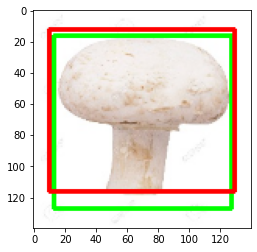

In [53]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    image , gt_bbox = validset[1]  # (c, h, w)
    image = image.unsqueeze(0).to(DEVICE)

    out_bbox = model(image)

    utils.compare_plots(image, gt_bbox, out_bbox)